In [197]:
import logging
from itertools import combinations
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
import random
from icecream import ic
import math

logging.basicConfig(level=logging.DEBUG)

In [198]:
CITIES = pd.read_csv('cities/us.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head()

,name,lat,lon
0,Abilene,32.454514,-99.738147
1,Akron,41.080456,-81.521429
2,Albuquerque,35.105552,-106.647388
3,Alexandria,38.818343,-77.082026
4,Allen,33.107224,-96.674676


### Helper functions

In [199]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

class Individual:
    def __init__(self, genome):
        self.genome = genome
        self.fitness = -tsp_cost(genome)  

#Parent selection
def parent_selection(population):
    candidates = sorted(random.sample(population, 3), key=lambda e: e.fitness, reverse=True)
    return candidates[0]

#Crossover 
def xover(p1: Individual, p2: Individual):
    start, end = sorted(random.sample(range(1, len(CITIES)), 2))
    
    #PMX crossover
    child_genome = [None] * len(CITIES)
    child_genome[start:end] = p1.genome[start:end]

    p2_pointer = 0
    for i in range(len(CITIES)):
        if child_genome[i] is None:
            while p2.genome[p2_pointer] in child_genome:
                p2_pointer += 1
            child_genome[i] = p2.genome[p2_pointer]

    child_genome.append(child_genome[0])

    if random.random() < 0.5:
        child_genome = cycle_crossover(p1.genome, p2.genome)

    return Individual(child_genome)

#CX crossover
def cycle_crossover(p1_genome, p2_genome):
    child_genome = [None] * len(p1_genome)
    cycle = set()
    start = 1  
    while len(cycle) < len(p1_genome) - 1:
        if start not in cycle:
            cycle.add(start)
            index = p1_genome.index(p2_genome[start])
            while index not in cycle:
                cycle.add(index)
                index = p1_genome.index(p2_genome[index])
        start += 1
    for i in cycle:
        child_genome[i] = p1_genome[i]
    for i in range(len(child_genome)):
        if child_genome[i] is None:
            child_genome[i] = p2_genome[i]
    child_genome[0] = child_genome[-1] = p1_genome[0]
    return child_genome

#Mutation
def mutation(p: Individual):
    genome = p.genome.copy()

    points = sorted(random.sample(range(1, len(genome) - 1), random.randint(3, 5)))
    segments = [genome[points[i]:points[i + 1]] for i in range(len(points) - 1)]
   
    inverted_segments = [seg[::-1] if random.random() < 0.5 else seg for seg in segments]
    new_genome = genome[:points[0]] + sum(inverted_segments, []) + genome[points[-1]:]

    if random.random() < 0.3:  
        start, end = sorted(random.sample(range(1, len(new_genome) - 1), 2))
        segment = new_genome[start:end]
        new_genome = new_genome[:start] + new_genome[end:]
        insert_pos = random.randint(1, len(new_genome) - 1)
        new_genome = new_genome[:insert_pos] + segment + new_genome[insert_pos:]

    return Individual(new_genome)

## Greedy Nearest Neighbor

In [200]:
def greedy_nearest_neighbor():
    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    city = 0
    visited[city] = True
    tsp = list()
    tsp.append(int(city))
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        logging.debug(
            f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
        )
        visited[closest] = True
        city = closest
        tsp.append(int(city))
    logging.debug(
        f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)"
    )
    tsp.append(tsp[0])
    logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km")
    return Individual(tsp)
    

## Greedy MST based

In [201]:
def cyclic(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    try:
        nx.find_cycle(G)
        return True
    except:
        return False

In [202]:
def greedy_mst_based():
    segments = [
        ({c1, c2}, float(DIST_MATRIX[c1, c2])) for c1, c2 in combinations(range(len(CITIES)), 2)
    ]
    visited = {0}  
    edges = set()
    segments = sorted(segments, key=lambda e: e[1])
    
    for (edge, dist) in segments:
        if len(visited) == len(CITIES):  
            break
        if edge & visited:
            if not cyclic(edges | {tuple(edge)}):
                edges.add(tuple(edge))
                visited.update(edge)
    
    if visited:
        tsp = list(visited) + [list(visited)[0]]  
    else:
        tsp = []

    return Individual(tsp)

# EA implementation

DEBUG:matplotlib:matplotlib data path: c:\Users\Sergio\Desktop\2 Anno Magistrale\Computational Intelligence\Codice\CI2024\Lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\Sergio\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\Sergio\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\Sergio\.matplotlib\fontlist-v390.json
DEBUG:root:step: Abilene -> Wichita Falls (196.78km)
DEBUG:root:step: Wichita Falls -> Denton (149.68km)
DEBUG:root:step: Denton -> Lewisville (23.92km)
DEBUG:root:step: Lewisville -> Carrollton (10.02km)
DEBUG:root:step: Carrollton -> Plano (15.78km)
DEBUG:root:step: Plano -> Allen (9.27km)
DEBUG:root:step: Allen -> McKinney (10.45km)
DEBUG:root:step: McKinney -> Frisco (15.17km)
DEBUG:root:step: Frisco -> Richardson (22.38km)
DEBUG:root:step: Richardson -> Garland (10.04km)
DEBUG:root:step: Garland -> Mesquite (16.57km)
DEBUG:root:step: Mesq

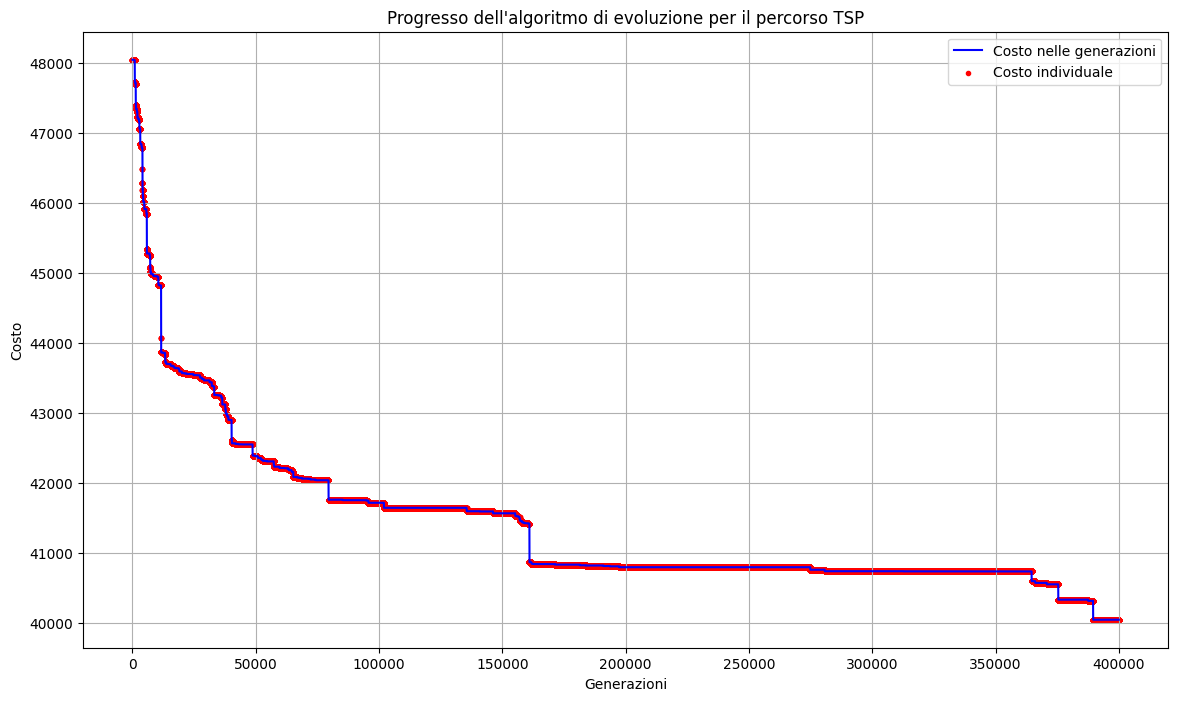

In [203]:
import matplotlib.pyplot as plt

POPULATION_SIZE = 100  
OFFSPRING_SIZE = 20   

# Inizializzazione popolazione di percorsi iniziali trovati con metodi greedy
population = [greedy_nearest_neighbor(), greedy_mst_based()]

# Aggiunta individui casuali per completare la popolazione
for _ in range(POPULATION_SIZE - len(population)):
    random_path = list(range(len(CITIES)))
    random.shuffle(random_path)
    random_path.append(random_path[0])  
    population.append(Individual(random_path))

def evolve(population, generations=200_000, mutation_rate=0.3, initial_temperature=10_000.0, cooling_rate=0.995, stagnation_limit=5_000, adaptive_increase=0.1):
    best_path = max(population, key=lambda ind: ind.fitness)
    current_best = best_path
    temperature = initial_temperature
    stagnation_counter = 0  
    base_mutation_rate = mutation_rate  
    history = []  
    
    logging.info(f"Percorso iniziale migliore: Costo del percorso: {-best_path.fitness:.2f} km")
    
    for generation in range(generations):
        offspring = []
        for _ in range(OFFSPRING_SIZE):
            if random.random() < mutation_rate:
                parent = parent_selection(population)
                child = mutation(parent)
            else:
                parent1 = parent_selection(population)
                parent2 = parent_selection(population)
                child = xover(parent1, parent2)
            offspring.append(child)

        improved = False
        for child in offspring:
            child.fitness = -tsp_cost(child.genome)
            delta_fitness = child.fitness - current_best.fitness

            if delta_fitness > 0 or random.random() < np.exp(delta_fitness / temperature):
                current_best = child
                if child.fitness > best_path.fitness:
                    best_path = child
                    improved = True
                    stagnation_counter = 0
        
        if not improved:
            stagnation_counter +=1
        
        if stagnation_counter >= stagnation_limit:
            mutation_rate = min(1.0, mutation_rate + adaptive_increase)

        if improved: 
            mutation_rate = base_mutation_rate

        population.extend(offspring)
        population.sort(key=lambda ind: ind.fitness, reverse=True)
        population = population[:POPULATION_SIZE]

        temperature *= cooling_rate
        
        history.append(-best_path.fitness)

        if generation % 10_000 == 0:
            logging.info(f"Generazione {generation}: Costo del miglior percorso: {-best_path.fitness:.2f} km")
            random_path = list(range(len(CITIES)))
            random.shuffle(random_path)
            random_path.append(random_path[0]) 
            population.append(Individual(random_path))
    
    return best_path, history

best_path, history = evolve(population)

second_phase_population = [best_path]

for _ in range(POPULATION_SIZE - 1):
    random_path = list(range(len(CITIES)))
    random.shuffle(random_path)
    random_path.append(random_path[0])  
    second_phase_population.append(Individual(random_path))

best_path_final, history_final = evolve(
    second_phase_population,
    generations=200_000,           
    mutation_rate=0.4,            
    initial_temperature=10_000.0,   
    cooling_rate=0.998,            
    stagnation_limit=5_000, 
    adaptive_increase=0.1
)

logging.info(f"Percorso migliore trovato: {best_path_final.genome}")
logging.info(f"Costo del percorso migliore: {tsp_cost(best_path_final.genome):.2f} km")

# Grafico per visualizzare il progresso dell'algoritmo
plt.figure(figsize=(14, 8))
plt.plot(range(len(history + history_final)), history + history_final, color="blue", label="Costo nelle generazioni")
plt.scatter(range(len(history + history_final)), history + history_final, color="red", marker=".", label="Costo individuale")
plt.title("Progresso dell'algoritmo di evoluzione per il percorso TSP")
plt.xlabel("Generazioni")
plt.ylabel("Costo")
plt.legend()
plt.grid(True)
plt.show()

logging.info(f"Percorso migliore trovato: {best_path_final.genome}")
logging.info(f"Costo del percorso migliore: {tsp_cost(best_path_final.genome):.2f} km")
